In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt

In [3]:
master_df = pd.read_csv("/content/drive/MyDrive/NYC/2021_Yellow_Taxi_Trip_Data-2.csv",low_memory=False)
print(master_df.head())  

   VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0         1  01/01/2021 12:30:10 AM  01/01/2021 12:36:12 AM              1.0   
1         1  01/01/2021 12:51:20 AM  01/01/2021 12:52:19 AM              1.0   
2         1  01/01/2021 12:43:30 AM  01/01/2021 01:11:06 AM              1.0   
3         1  01/01/2021 12:15:48 AM  01/01/2021 12:31:01 AM              0.0   
4         1  01/01/2021 12:16:29 AM  01/01/2021 12:24:30 AM              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            2.1         1.0                  N           142            43   
1            0.2         1.0                  N           238           151   
2           14.7         1.0                  N           132           165   
3           10.6         1.0                  N           138           132   
4            1.6         1.0                  N           224            68   

   payment_type  fare_amount  extra  mta_tax

# Pre-Processing

In [4]:
master_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,01/01/2021 12:30:10 AM,01/01/2021 12:36:12 AM,1.0,2.1,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5
1,1,01/01/2021 12:51:20 AM,01/01/2021 12:52:19 AM,1.0,0.2,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
2,1,01/01/2021 12:43:30 AM,01/01/2021 01:11:06 AM,1.0,14.7,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0
3,1,01/01/2021 12:15:48 AM,01/01/2021 12:31:01 AM,0.0,10.6,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0
4,1,01/01/2021 12:16:29 AM,01/01/2021 12:24:30 AM,1.0,1.6,1.0,N,224,68,1,8.0,3.0,0.5,2.35,0.0,0.3,14.15,2.5


In [5]:
#finding outliers in tip amount
master_df['tip_amount'].nlargest(10)

244852     1140.44
7421451     999.99
7460221     780.00
1335925     700.00
8143419     650.00
6249900     500.00
8058637     400.04
704859      400.00
2264412     400.00
18687       369.40
Name: tip_amount, dtype: float64

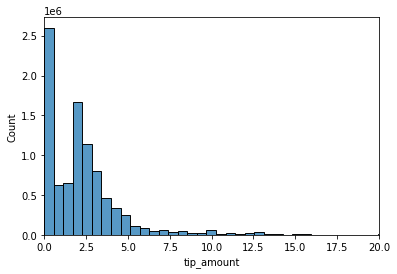

In [6]:
plt.xlim(0,20)
sns.histplot(data=master_df, x="tip_amount",bins =2000)
plt.show()

In [7]:
master_df['tip_amount'].value_counts()

0.00     2563738
1.00      530092
2.00      489314
2.45      186286
2.05      177429
          ...   
79.40          1
52.35          1
58.86          1
75.30          1
18.53          1
Name: tip_amount, Length: 2867, dtype: int64

**Discovered that a lot of people are tipping almost 0 dollars. Need to find the reason behind this.**

In [8]:
for i in range(7):
  print("Payment type " +str(i)+ " customer count: ",len(master_df[(master_df['payment_type']==i)]))

Payment type 0 customer count:  103014
Payment type 1 customer count:  6932977
Payment type 2 customer count:  2018701
Payment type 3 customer count:  113155
Payment type 4 customer count:  46910
Payment type 5 customer count:  4
Payment type 6 customer count:  0


In [9]:
no_tip_count=master_df.groupby('payment_type')['tip_amount'].apply(lambda x: (x==0).sum()).reset_index(name='count')
print(no_tip_count)

   payment_type    count
0             0     2361
1             1   382800
2             2  2018586
3             3   113089
4             4    46898
5             5        4


From above we can see, that 99% of the customers paying using the paymment type 2(cash), 3(no charge), 4(dispute) and 5(unknown) are tipping 0 dollars. The reason behind this is that cash tips are not recorded in the dataset. Other payment type tips are also either not recorded or have faulty data collection. Either ways, we need to drop these rows to reduce the noise. 

In [10]:
master_df.shape

(9214761, 18)

In [11]:
#Dropped rows where payment is not done by credit card and where fare amount is not greater than zero
master_df = master_df[(master_df.payment_type==1) & (master_df.fare_amount >0)]

In [12]:
master_df.shape

(6931657, 18)

In [13]:
#Converted to date time format
master_df['tpep_pickup_datetime'] = pd.to_datetime(master_df['tpep_pickup_datetime'], format = '%m/%d/%Y %I:%M:%S %p', errors = 'raise')
master_df['tpep_dropoff_datetime'] = pd.to_datetime(master_df['tpep_dropoff_datetime'], format = '%m/%d/%Y %I:%M:%S %p', errors = 'raise')

In [14]:
master_df['pickup_weekday']=master_df.tpep_dropoff_datetime.dt.dayofweek

In [15]:
master_df['pickup_weekday'].value_counts()

4    1100066
3    1081351
2    1072089
1    1012692
5     990357
0     897415
6     777687
Name: pickup_weekday, dtype: int64

In [16]:
master_df['pickup_hour']=master_df.tpep_pickup_datetime.dt.hour

In [17]:
master_df['pickup_hour'].value_counts()

18    518534
17    511561
15    482815
16    474118
14    466207
19    444417
13    428644
12    412704
11    375158
20    350534
10    341406
21    313027
9     312064
8     290755
22    284742
23    218644
7     208661
0     146266
6     105120
1      92116
2      60541
3      36980
5      33156
4      23487
Name: pickup_hour, dtype: int64

In [18]:
master_df.loc[ (master_df['pickup_hour'] >= 0) & (master_df['pickup_hour'] < 6), 'pickup_hour'] = 0    # 0 - Early Morning
master_df.loc[ (master_df['pickup_hour'] >= 6) & (master_df['pickup_hour'] < 12), 'pickup_hour'] = 1    # 1 - Morning
master_df.loc[ (master_df['pickup_hour'] >= 12) & (master_df['pickup_hour'] < 18), 'pickup_hour'] = 2    # 2 - Afternoon
master_df.loc[ (master_df['pickup_hour'] >= 18) & (master_df['pickup_hour'] <= 23), 'pickup_hour'] = 3    # 3 - Night

In [19]:
tip_by_daytime =master_df.groupby('pickup_hour')['tip_amount'].apply(lambda x: x.mean()).reset_index(name='mean')
print(tip_by_daytime)

   pickup_hour      mean
0            0  3.136492
1            1  2.833926
2            2  2.992721
3            3  2.997179


In [20]:
master_df['dropoff_weekday']=master_df.tpep_dropoff_datetime.dt.dayofweek

In [21]:
master_df['dropoff_weekday'].value_counts()

4    1100066
3    1081351
2    1072089
1    1012692
5     990357
0     897415
6     777687
Name: dropoff_weekday, dtype: int64

In [22]:
master_df['drop_hour']=master_df.tpep_dropoff_datetime.dt.hour

In [23]:
master_df['drop_hour'].value_counts()

18    534685
17    507538
15    477715
16    474027
19    472318
14    450360
13    420932
12    405862
20    367413
11    363350
10    333358
21    318303
9     308906
22    292728
8     274941
23    234669
7     182728
0     162411
1     102012
6      88199
2      66401
3      40269
5      27405
4      25127
Name: drop_hour, dtype: int64

In [24]:
master_df['RatecodeID'].value_counts()

1.0     6729335
2.0      151117
5.0       23443
3.0       11324
99.0      10726
4.0        5707
6.0           5
Name: RatecodeID, dtype: int64

In [25]:
#Dropped rows where Ratecode ID is 99 beacause rate code ID 99 is not defined
master_df=master_df[master_df.RatecodeID!=99.0]

In [26]:
Location_lookup = pd.read_csv("/content/drive/MyDrive/NYC/taxi+_zone_lookup.csv",low_memory=False)

In [27]:
master_df1 = pd.merge(master_df,Location_lookup,how ='inner',left_on=master_df['PULocationID'],right_on =Location_lookup['LocationID'] )

In [28]:
master_df1.head(10)

,key_0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,total_amount,congestion_surcharge,pickup_weekday,pickup_hour,dropoff_weekday,drop_hour,LocationID,Borough,Zone,service_zone
0,132,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.7,1.0,N,132,165,...,51.95,0.0,4,0,4,1,132,Queens,JFK Airport,Airports
1,132,1,2021-01-01 00:22:52,2021-01-01 00:43:49,1.0,17.2,2.0,N,132,107,...,73.67,2.5,4,0,4,0,132,Queens,JFK Airport,Airports
2,132,1,2021-01-01 00:29:16,2021-01-01 00:40:18,1.0,5.3,1.0,N,132,139,...,22.25,0.0,4,0,4,0,132,Queens,JFK Airport,Airports
3,132,1,2021-01-01 00:49:24,2021-01-01 01:28:19,3.0,17.5,1.0,N,132,62,...,56.80,0.0,4,0,4,1,132,Queens,JFK Airport,Airports
4,132,1,2021-01-01 00:28:31,2021-01-01 00:48:37,1.0,14.5,1.0,N,132,7,...,48.35,0.0,4,0,4,0,132,Queens,JFK Airport,Airports
5,132,1,2021-01-01 01:16:47,2021-01-01 01:39:27,1.0,18.0,2.0,Y,132,4,...,55.30,2.5,4,0,4,1,132,Queens,JFK Airport,Airports
6,132,1,2021-01-01 02:05:15,2021-01-01 02:38:00,0.0,18.9,2.0,N,132,230,...,61.42,2.5,4,0,4,2,132,Queens,JFK Airport,Airports
7,132,1,2021-01-01 04:44:47,2021-01-01 05:16:17,1.0,14.7,1.0,N,132,62,...,47.80,0.0,4,0,4,5,132,Queens,JFK Airport,Airports
8,132,1,2021-01-01 05:41:02,2021-01-01 05:59:06,2.0,8.5,1.0,N,132,38,...,31.55,0.0,4,0,4,5,132,Queens,JFK Airport,Airports
9,132,1,2021-01-01 05:43:57,2021-01-01 06:15:42,0.0,19.8,2.0,N,132,140,...,71.42,2.5,4,0,4,6,132,Queens,JFK Airport,Airports


In [29]:
master_df1.loc[ master_df1['Borough'] == 'Queens' , 'Pickup_Area'] = 1
master_df1.loc[ master_df1['Borough'] == 'Bronx' , 'Pickup_Area'] = 2
master_df1.loc[ master_df1['Borough'] == 'Brooklyn' , 'Pickup_Area'] = 3
master_df1.loc[ master_df1['Borough'] == 'Staten Island' , 'Pickup_Area'] = 4
master_df1.loc[ master_df1['Borough'] == 'Manhattan' , 'Pickup_Area'] = 5
master_df1.loc[ (master_df1['Zone'] == 'Newark Airport') | (master_df1['Zone']  == 'JFK Airport') | (master_df1['Zone']  == 'LaGuardia Airport') | (master_df1['Borough'] == 'Unknown' ),  'Pickup_Area'] = 6 #Airport Area

In [30]:
master_df1['Pickup_Area'].value_counts()

5.0    6413927
6.0     407106
1.0      45765
3.0      41693
2.0      12392
4.0         48
Name: Pickup_Area, dtype: int64

In [31]:
master_df1['Pickup_Area'].isnull().sum()

0

In [32]:
master_df1 = master_df1.drop(['key_0','Borough','service_zone','LocationID','Zone'],axis=1)

In [33]:
master_df = pd.merge(master_df1,Location_lookup,how ='inner',left_on=master_df['DOLocationID'],right_on =Location_lookup['LocationID'] )

In [34]:
master_df.loc[ master_df['Borough'] == 'Queens' , 'Dropoff_Area'] = 1
master_df.loc[ master_df['Borough'] == 'Bronx' , 'Dropoff_Area'] = 2
master_df.loc[ master_df['Borough'] == 'Brooklyn' , 'Dropoff_Area'] = 3
master_df.loc[ master_df['Borough'] == 'Staten Island' , 'Dropoff_Area'] = 4
master_df.loc[ master_df['Borough'] == 'Manhattan' , 'Dropoff_Area'] = 5
master_df.loc[ (master_df['Zone'] == 'Newark Airport') | (master_df['Zone']  == 'JFK Airport') | (master_df['Zone']  == 'LaGuardia Airport') | (master_df['Borough'] == 'Unknown' ),  'Dropoff_Area'] = 6 #Airport Area

In [35]:
master_df['Dropoff_Area'].value_counts()

5.0    6340431
3.0     244242
6.0     151073
1.0     142539
2.0      41464
4.0       1182
Name: Dropoff_Area, dtype: int64

In [36]:
master_df['Dropoff_Area'].isnull().sum()

0

In [37]:
master_df = master_df.drop(['key_0','Borough','service_zone','LocationID','Zone','PULocationID','DOLocationID','VendorID','payment_type'],axis=1)

In [38]:
master_df.head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_weekday,pickup_hour,dropoff_weekday,drop_hour,Pickup_Area,Dropoff_Area
0,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.7,1.0,N,42.0,0.50,0.5,8.65,0.00,0.3,51.95,0.0,4,0,4,1,6.0,3.0
1,2021-02-04 15:12:48,2021-02-04 15:56:26,1.0,12.5,1.0,N,40.0,0.00,0.5,5.00,0.00,0.3,45.80,0.0,3,2,3,15,6.0,3.0
2,2021-03-23 15:47:15,2021-03-23 16:47:09,1.0,14.3,1.0,N,48.0,1.00,0.5,9.95,0.00,0.3,59.75,0.0,1,2,1,16,6.0,3.0
3,2021-03-27 20:29:59,2021-03-27 21:14:14,1.0,25.2,1.0,N,68.5,0.50,0.5,13.95,0.00,0.3,83.75,0.0,5,3,5,21,6.0,3.0
4,2021-04-14 23:07:30,2021-04-14 23:36:41,1.0,19.2,2.0,N,52.0,3.75,0.5,12.60,6.55,0.3,75.70,2.5,2,3,2,23,6.0,3.0
5,2021-04-21 06:09:57,2021-04-21 06:46:51,1.0,15.4,1.0,N,43.0,1.25,0.5,9.00,0.00,0.3,54.05,0.0,2,1,2,6,6.0,3.0
6,2021-04-21 12:35:20,2021-04-21 13:15:57,1.0,19.0,2.0,N,52.0,3.75,0.5,12.60,6.55,0.3,75.70,2.5,2,2,2,13,6.0,3.0
7,2021-04-29 13:33:17,2021-04-29 14:25:38,2.0,18.4,1.0,N,54.0,1.25,0.5,11.20,0.00,0.3,67.25,0.0,3,2,3,14,6.0,3.0
8,2021-05-21 15:34:10,2021-05-21 16:21:54,1.0,17.2,2.0,N,52.0,2.50,0.5,6.00,6.55,0.3,67.85,2.5,4,2,4,16,6.0,3.0
9,2021-05-22 21:41:51,2021-05-22 22:20:47,1.0,17.5,1.0,N,49.5,1.75,0.5,13.00,0.00,0.3,65.05,0.0,5,3,5,22,6.0,3.0


In [39]:
# master_df['tip_fraction'] =  master_df.tip_amount/master_df.fare_amount

In [40]:
master_df['z_score'] = (master_df['tip_amount'] - master_df['tip_amount'].mean()) / master_df['tip_amount'].std(ddof=0)

In [41]:
#remove outliers beyond the third standard deviation point
master_df = master_df[(np.abs(stats.zscore(master_df['z_score'])) < 3)]

In [42]:
master_df['tip_amount'].describe()

count    6.787387e+06
mean     2.730372e+00
std      1.835045e+00
min      0.000000e+00
25%      1.750000e+00
50%      2.350000e+00
75%      3.300000e+00
max      1.143000e+01
Name: tip_amount, dtype: float64

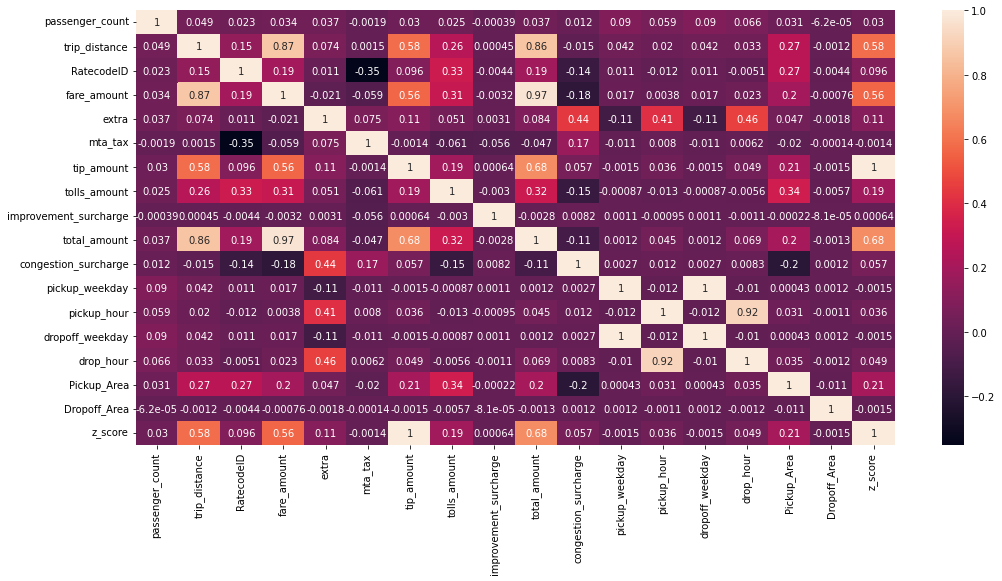

In [43]:
plt.figure(figsize=(17,8))
sns.heatmap(master_df.corr('spearman'), annot = True)

In [44]:
master_df['tip_amount'].describe()

count    6.787387e+06
mean     2.730372e+00
std      1.835045e+00
min      0.000000e+00
25%      1.750000e+00
50%      2.350000e+00
75%      3.300000e+00
max      1.143000e+01
Name: tip_amount, dtype: float64

In [45]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
        master_df[['trip_distance', 'RatecodeID','total_amount','tolls_amount','extra','pickup_hour','pickup_weekday','Pickup_Area','Dropoff_Area']], 
        master_df['tip_amount'], 
        test_size=0.3,
        train_size=0.7,        
        random_state=42
    )

# Linear Regression

In [ ]:
model = LinearRegression()
model.fit(X_train_base, y_train_base)
preds = model.predict(X_test_base)

In [ ]:
print("R-squared value: ", r2_score(y_test_base,preds))
print("RMSE of Linear Regression: ", (mean_squared_error(y_test_base,preds))**(1/2) )

R-squared value:  0.5144612215048884
RMSE of Linear Regression:  1.2793281077869054


# Decision Tree Regressor

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
depths = [1,5,10,15,20,35,50]
tree_MSE = []
for i in depths:
  tree_model = DecisionTreeRegressor(max_depth = i)
  tree_model.fit(X_train_base, y_train_base)
  tree_test_mse = (mean_squared_error(y_test_base, tree_model.predict(X_test_base)))**(1/2)
  tree_MSE.append(tree_test_mse)
print(tree_MSE)

[1.474839367604275, 1.1152116278503437, 0.8833815023683835, 0.7412141250474886, 0.7384451360596642, 0.8145515834662722, 0.8165881162660311]


In [ ]:
tree_model = DecisionTreeRegressor(max_depth = 20)
tree_model.fit(X_train_base, y_train_base)

DecisionTreeRegressor(max_depth=20)

In [ ]:
tree_test_mse = (mean_squared_error(y_test_base, tree_model.predict(X_test_base)))**(1/2)
print("RMSE of Decision Tree Regressor: ",tree_test_mse)

RMSE of Decision Tree Regressor:  0.738223552095929


# Random Forest Regressor

In [46]:
random_grid = {'max_depth': [5,10,15,20,25, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20,60,100,150,200]}

In [51]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv =2, n_iter = 50, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(X_train_base, y_train_base)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
rf_random.best_params_

In [ ]:
rf_random.best_score_

In [ ]:
rf_model = RandomForestRegressor(n_estimators= 150, min_samples_split= 10, min_samples_leaf= 4, max_features= 'sqrt', max_depth= 15, n_jobs = -1)
rf_model.fit(X_train_base, y_train_base)

[2.83571635e-01 1.46613843e-02 5.61553034e-01 3.77139612e-02
 5.36908500e-02 2.70374975e-03 2.07782189e-03 4.36863882e-02
 3.41175162e-04]
0.8248159744198297


In [ ]:
rf_test_mse = (mean_squared_error(y_test_base, rf_model.predict(X_test_base)))**(1/2)
print("Feature Importance:")
print(rf_model.feature_importances_)
print("RMSE of Random Forest Regressor: ",rf_test_mse)

# K Neighbours Regressor

**SCALING OF DATA**

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train_base)
X_test=sc_X.fit_transform(X_test_base)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
model = KNeighborsRegressor()

In [ ]:
model.fit(X_train, y_train_base)

KNeighborsRegressor()

In [ ]:
rmse = (mean_squared_error(y_test_base, model.predict(X_test)))**(1/2)
print("RMSE of K Neighbours Regressor: ",rmse)

# XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [ ]:
XGmodel = XGBRegressor()

In [ ]:
XGmodel.fit(X_train_base, y_train_base)
XG_test_mse = (mean_squared_error(y_test_base, XGmodel.predict(X_test_base)))**(1/2)
print(XG_test_mse)

[16:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:31] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
1.0416610510310964


In [ ]:
random_grid_XG = {'max_depth': [2,5,8, None],
 'learning_rate': [0.5, 0.3, 0.1, 0.01],
 'subsample': [0.25,0.5,0.75],
 'n_estimators': [20,60,100,150,200]}

In [ ]:
XG_random = RandomizedSearchCV(estimator = XGmodel, param_distributions = random_grid_XG, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
XG_random.fit(X_train_base, y_train_base)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
51 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
51 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py", line 391, in fit
    self._Booster = train(params, trainDmatrix,
  File "/usr/local/lib/python3.8/dist-packages/xgboost/training.py", line 212, in train
    return _train_internal(params, dtrain,
  File "/usr/local/lib/python3.8/dist-packages/xgboos

[19:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:07] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


RandomizedSearchCV(cv=3, estimator=XGBRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.5, 0.3, 0.1, 0.01],
                                        'max_depth': [2, 5, 8, None],
                                        'n_estimators': [20, 60, 100, 150, 200],
                                        'subsample': [0.25, 0.5, 0.75]},
                   random_state=42, verbose=2)

In [ ]:
XG_random.best_params_

{'subsample': 0.75, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.3}

In [ ]:
XG_random.best_score_

0.8563787824192771

In [ ]:
XGmodel_final = XGBRegressor(subsample=  0.75, n_estimators= 200, max_depth =  8, learning_rate = 0.3)
XGmodel_final.fit(X_train_base, y_train_base)

[20:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:26] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(learning_rate=0.3, max_depth=8, n_estimators=200, subsample=0.75)

In [ ]:
XG_test_mse = (mean_squared_error(y_test_base, XGmodel_final.predict(X_test_base)))**(1/2)
print("RMSE of XGBoost Regressor: ",XG_test_mse)

RMSE of XGBoost Regressor:  0.9415014978934526


# Neural Nets

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [ ]:
def baseline_model():
 # create model
 model = Sequential()
 model.add(Dense(9, input_shape=(9,), kernel_initializer='normal', activation='relu'))
 model.add(Dense(1, kernel_initializer='normal'))
 # Compile model
 model.compile(loss='mean_squared_error', optimizer='adam')
 return model

In [ ]:
from sklearn.pipeline import Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(baseline_model, epochs=100, batch_size= 80000 , verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X_train_base, y_train_base, cv=kfold, scoring='neg_root_mean_squared_error')

<ipython-input-62-945f6175ccd8>:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append(('mlp', KerasRegressor(baseline_model, epochs=100, batch_size= 80000 , verbose=0)))


In [ ]:
print(results)
print(results.mean()) #ignore the negative sign as we have considered the negative root mean squared error for scoring purposes.

[-1.02510815 -1.11426577 -0.96657277 -1.21359471 -0.97257785 -1.04775248
 -1.07212048 -0.99642483 -1.21611476 -1.06157561]
-1.0686107388876591


In [ ]:
def larger_model():
 # create model
 model = Sequential()
 model.add(Dense(20, input_shape=(9,), kernel_initializer='normal', activation='relu'))
 model.add(Dense(15, kernel_initializer='normal', activation='relu'))
 model.add(Dense(9, kernel_initializer='normal', activation='relu'))
 model.add(Dense(6, kernel_initializer='normal', activation='relu'))
 model.add(Dense(1, kernel_initializer='normal'))
 # Compile model
 model.compile(loss='mean_squared_error', optimizer='adam')
 print(model.summary())
 return model


In [ ]:
from sklearn.pipeline import Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(larger_model, epochs=100, batch_size= 80000 , verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X_train_base, y_train_base, cv=kfold, scoring='neg_root_mean_squared_error')

<ipython-input-65-cd3936fe2249>:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append(('mlp', KerasRegressor(larger_model, epochs=100, batch_size= 80000 , verbose=0)))


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 20)                200       
                                                                 
 dense_21 (Dense)            (None, 15)                315       
                                                                 
 dense_22 (Dense)            (None, 9)                 144       
                                                                 
 dense_23 (Dense)            (None, 6)                 60        
                                                                 
 dense_24 (Dense)            (None, 1)                 7         
                                                                 
Total params: 726
Trainable params: 726
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_11"
___________________________

In [ ]:
print(results)
print("RMSE of Neural Networks: ",abs(results.mean()))

[-0.89435799 -0.92414337 -0.88071438 -0.87562923 -0.86846095 -0.87058261
 -0.88097591 -0.87948471 -0.89063104 -0.86549951]
RMSE of Neural Networks:  0.8830479692574322
